# Assignment 2

In [5]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import chart_studio.plotly as py
import plotly.offline as po
import plotly.graph_objs as pg
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from urllib.request import urlopen
import json
import calplot 
from bokeh.plotting import figure
from bokeh.palettes import Plasma, Plasma256, Turbo256, RdYlGn, Bright6, Category20, magma
from bokeh.models import ColumnDataSource, HoverTool, FactorRange, Legend
from bokeh.io import output_file, show, output_notebook, push_notebook
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
#Read in data
data = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

#Convert data column to datetime format
data['Date'] =  pd.to_datetime(data['Date'])

#Make sure that data is limited to desired timeframe
data = data[(data['Date'] >= "2003-01-01") & (data['Date'] <= "2017-12-31")]

#### Create common foundation for the storyline:

In [7]:
#Chossing the area of crimes we want to look into
focuscrimes = set(['VANDALISM','VEHICLE THEFT'])

In [8]:
#Only look at focuscrimes
data = data[data['Category'].isin(focuscrimes)]

In [9]:
car_vandalism_theft = ['STOLEN AUTOMOBILE', 'STOLEN AND RECOVERED VEHICLE', 
                       'MALICIOUS MISCHIEF, TIRE SLASHING','ATTEMPTED STOLEN VEHICLE',
                       'MALICIOUS MISCHIEF, STREET CARS/BUSES','TAMPERING WITH A VEHICLE','STOLEN BUS',
                       'GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION','VEHICLE, RENTAL, FAILURE TO RETURN',
                       'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES']

In [10]:
data = data[data['Descript'].isin(car_vandalism_theft)]

### Bar-chart plot

In [11]:
####### Date-time FILTERS ########
#Convert the Time to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Extract the hour from the date column
data['hour'] = data['Time'].dt.hour

# Extract the year from the date column
data['year'] = data['Date'].dt.year

# Extract the day of the week from the date column
data['day_of_week'] = data['Date'].dt.dayofweek

# Group the data by category, day of the week, and hour
groupedHourWeek = data.groupby(['Descript', 'day_of_week', 'hour']).size().reset_index(name='count')

# Get the unique categories, within above grouping of week-day and hours
categoriesHourWeek = groupedHourWeek['Descript'].unique()

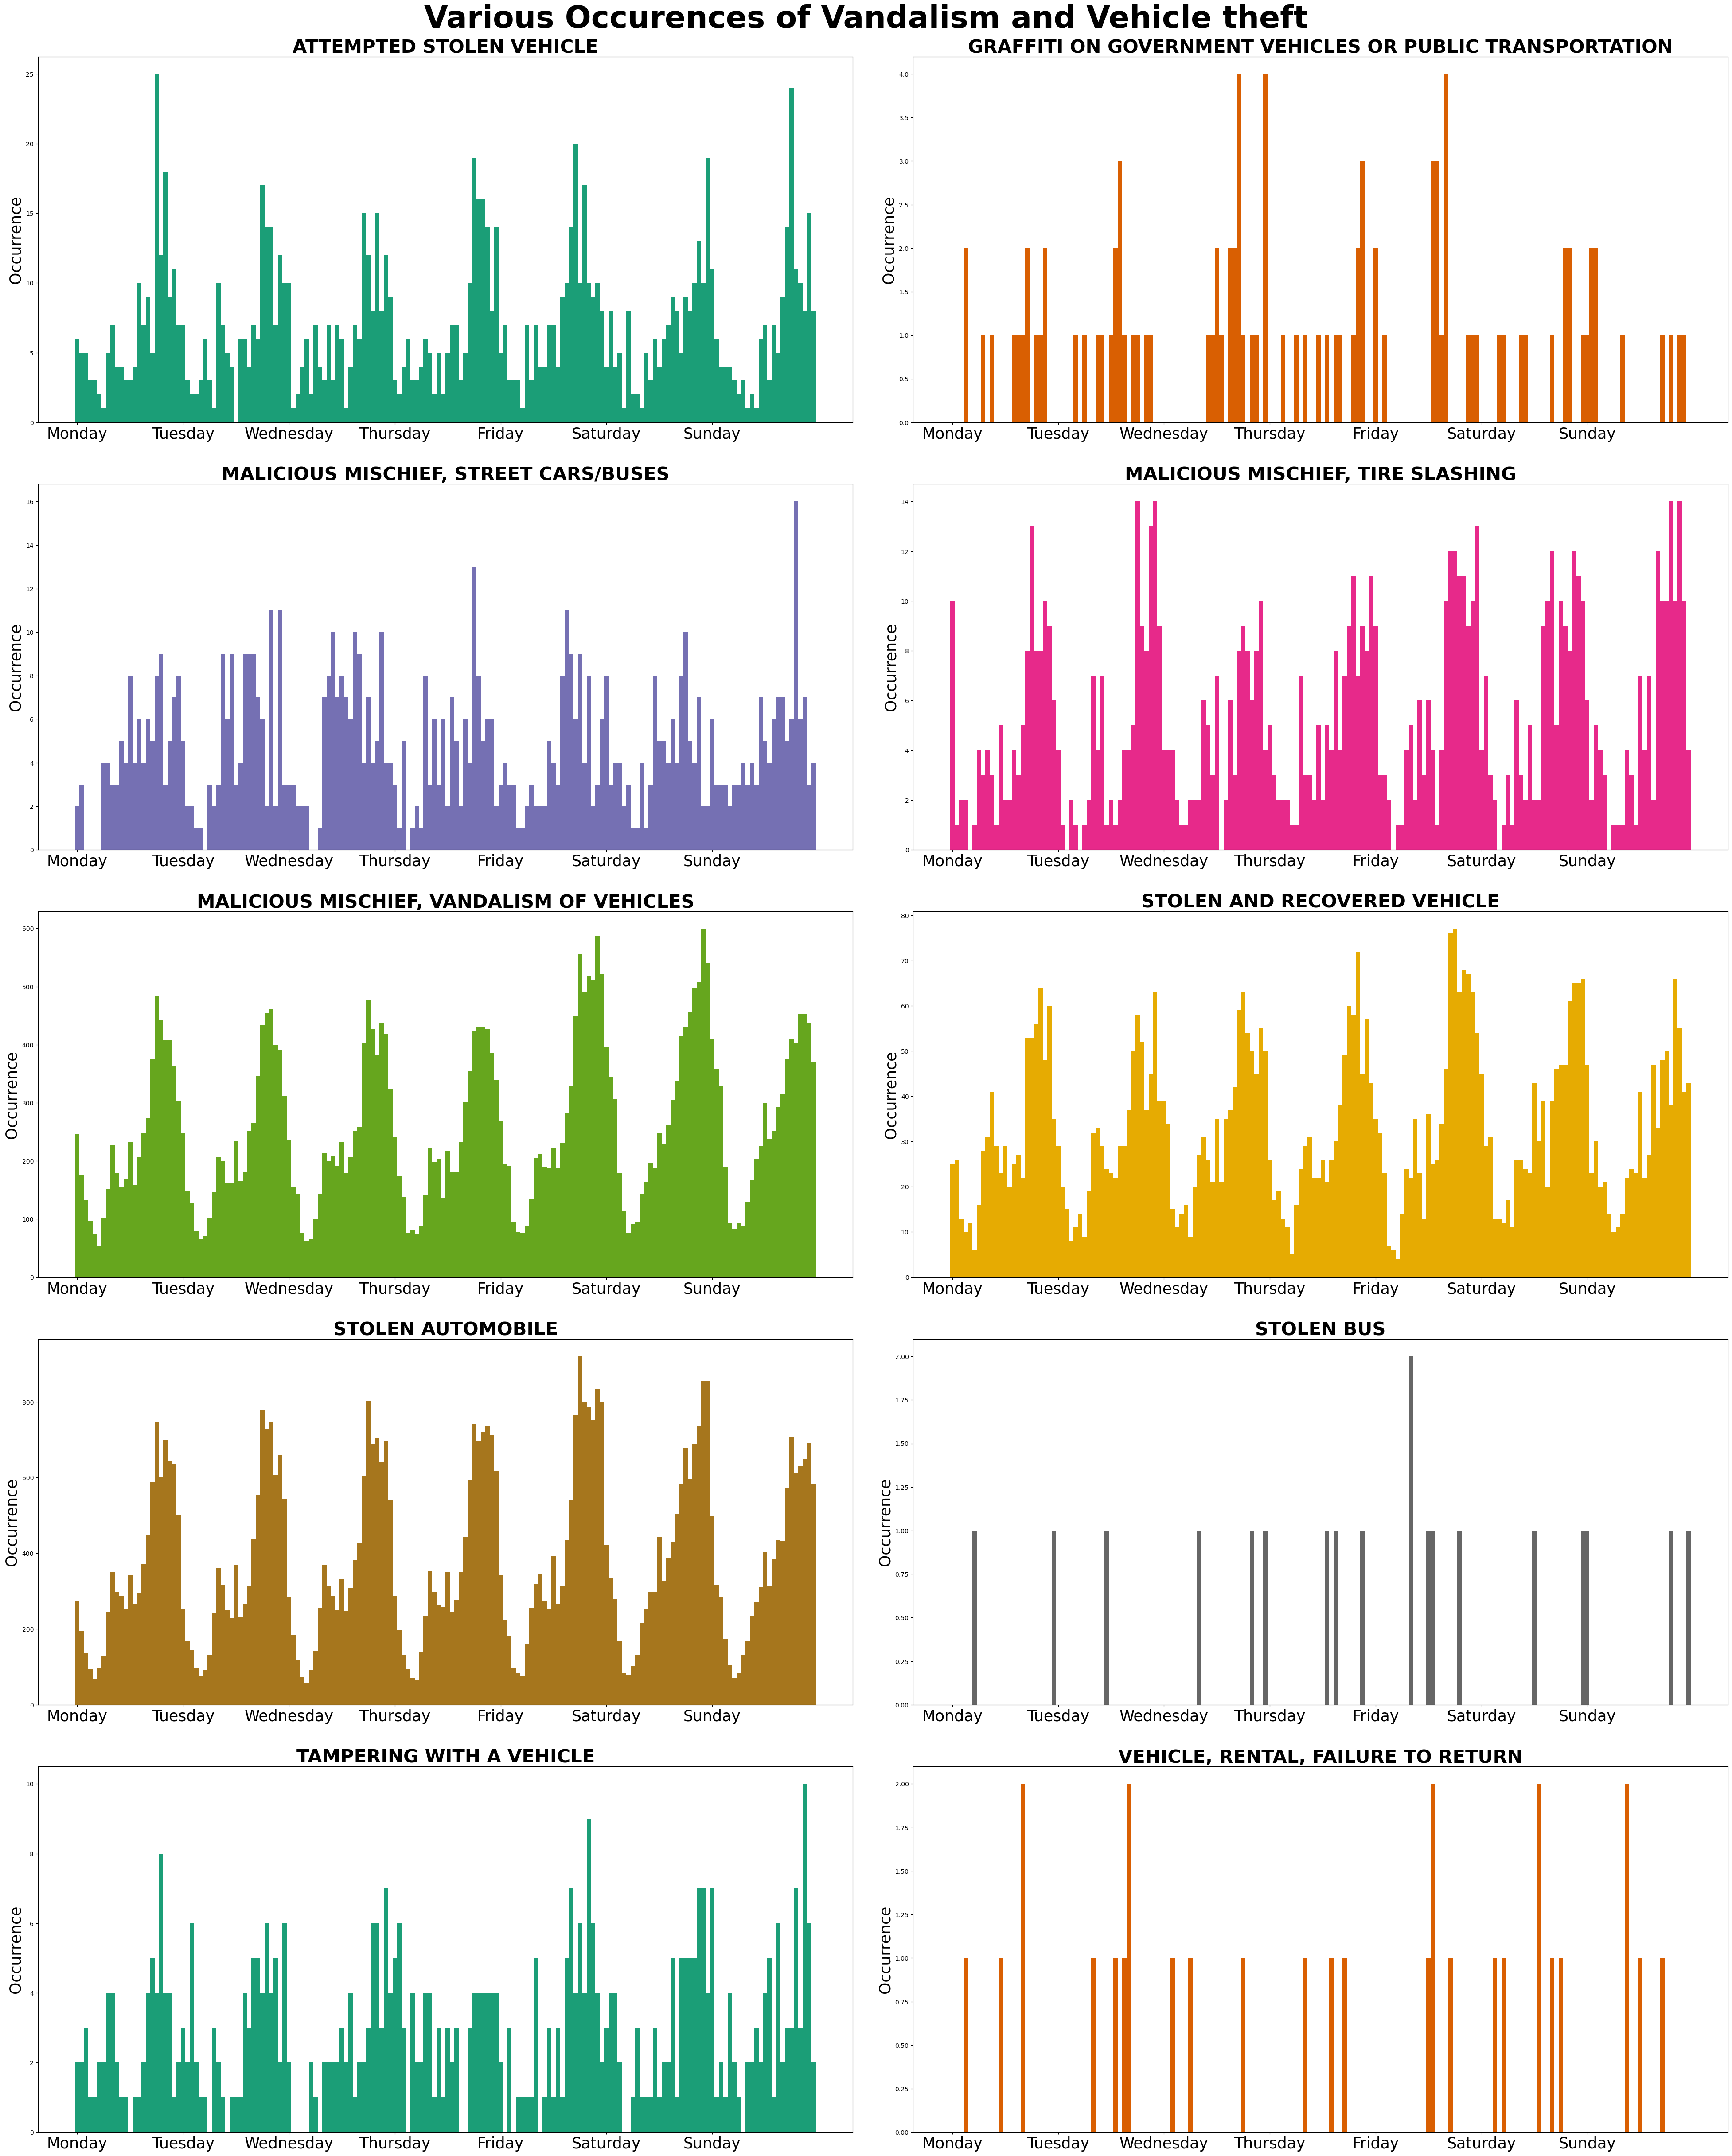

In [12]:
# Create a subplot with 1 rows and 2 columns
fig, axs = plt.subplots(5, 2, figsize=(40, 50))
# Flatten the axes array
axs = axs.flatten()


# Plot the bar chart for each focuscrime
for i, category in enumerate(categoriesHourWeek):
    data_sub = groupedHourWeek[groupedHourWeek['Descript'] == category]
    #Colormap for each category
    c = plt.cm.Dark2(i % plt.cm.Dark2.N)
    # Loop over each day of the week for each focuscrime
    for j, day_of_week in enumerate(range(7)):
        # Define day of the week, for use in the hour count
        data_sub_day = data_sub[data_sub['day_of_week'] == day_of_week]
        # Loop over every hour for every week-day for every focuscrime
        for hour in range(24):
            # Count the number of occurrences of crimes per hour
            count = data_sub_day[data_sub_day['hour'] == hour]['count'].sum()
            axs[i].bar(day_of_week*24 + hour, count, width=1, color=c)
    axs[i].set_title(category,fontsize=30,fontweight='bold')
    axs[i].set_xticks(range(0, 168, 24))
    axs[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=25)
    axs[i].set_ylabel('Occurrence',fontsize=25)

fig.suptitle('Various Occurences of Vandalism and Vehicle theft', fontsize=50,fontweight='bold')
plt.tight_layout(pad=4.0) 
plt.show()

### Map plots

In [13]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson') as response:
    counties = json.load(response)

#counties["features"][0]

In [14]:
car_vandalism = ['STOLEN AUTOMOBILE', 'STOLEN AND RECOVERED VEHICLE', 
                       'MALICIOUS MISCHIEF, TIRE SLASHING','ATTEMPTED STOLEN VEHICLE','TAMPERING WITH A VEHICLE',
                       'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES']

In [15]:
#Only look at focus crimes
data_sub_Vehicle = data[data['Descript'].isin(car_vandalism)]

In [16]:
#Only look at focus crimes
data_sub_Vehicle = data[data['Descript'].isin(car_vandalism)]

In [17]:
# Define dataset for days
data_sub_Vehicle_Mon = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Monday"]
data_sub_Vehicle_Tue = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Tuesday"]
data_sub_Vehicle_Wed = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Wednesday"]
data_sub_Vehicle_Thu = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Thursday"]
data_sub_Vehicle_Fri = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Friday"]
data_sub_Vehicle_Sat = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Saturday"]
data_sub_Vehicle_Sun = data_sub_Vehicle[data_sub_Vehicle['DayOfWeek']=="Sunday"]

In [18]:
#GroupBy police district
data_sub_Vehicle_Mon = data_sub_Vehicle_Mon.groupby(['PdDistrict']).size().reset_index(name='count')
data_sub_Vehicle_Tue = data_sub_Vehicle_Tue.groupby(['PdDistrict']).size().reset_index(name='count')
data_sub_Vehicle_Wed = data_sub_Vehicle_Wed.groupby(['PdDistrict']).size().reset_index(name='count')
data_sub_Vehicle_Thu = data_sub_Vehicle_Thu.groupby(['PdDistrict']).size().reset_index(name='count')
data_sub_Vehicle_Fri = data_sub_Vehicle_Fri.groupby(['PdDistrict']).size().reset_index(name='count')
data_sub_Vehicle_Sat = data_sub_Vehicle_Sat.groupby(['PdDistrict']).size().reset_index(name='count')
data_sub_Vehicle_Sun = data_sub_Vehicle_Sun.groupby(['PdDistrict']).size().reset_index(name='count')

In [19]:
# Plot
fig_mon = px.choropleth_mapbox(data_sub_Vehicle_Mon,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Mon['count']), max(data_sub_Vehicle_Mon['count'])),
                              mapbox_style="carto-positron", 
                             #zoom=10, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})
        
fig_tue = px.choropleth_mapbox(data_sub_Vehicle_Tue,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Tue['count']), max(data_sub_Vehicle_Tue['count'])),
                              mapbox_style="carto-positron",
                              #zoom=10, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})

fig_wed = px.choropleth_mapbox(data_sub_Vehicle_Wed,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Wed['count']), max(data_sub_Vehicle_Wed['count'])),
                              mapbox_style="carto-positron",
                              #zoom=10, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})

fig_thu = px.choropleth_mapbox(data_sub_Vehicle_Thu,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Thu['count']), max(data_sub_Vehicle_Thu['count'])),
                              mapbox_style="carto-positron",
                              #zoom=10, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})
                              
fig_fri = px.choropleth_mapbox(data_sub_Vehicle_Fri,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Fri['count']), max(data_sub_Vehicle_Fri['count'])),
                              mapbox_style="carto-positron",
                              #zoom=10, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})

fig_sat = px.choropleth_mapbox(data_sub_Vehicle_Sat,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Sat['count']), max(data_sub_Vehicle_Sat['count'])),
                              mapbox_style="carto-positron",
                              #zoom=9, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})

fig_sun = px.choropleth_mapbox(data_sub_Vehicle_Sun,
                              locations='PdDistrict',
                              geojson=counties,
                              color='count',
                              color_continuous_scale="Viridis",
                              range_color=(min(data_sub_Vehicle_Sun['count']), max(data_sub_Vehicle_Sun['count'])),
                              mapbox_style="carto-positron",
                              #zoom=9, center = {"lat": 37.774, "lon": -122.4313},
                              opacity=0.5,)
                              #labels={'Index':'unemployment rate'})

fig = make_subplots(rows=4, cols=2,
                    subplot_titles=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                    specs=[[{'type': 'choroplethmapbox'}, {'type': 'choroplethmapbox'}], [{'type': 'choroplethmapbox'}, 
                    {'type': 'choroplethmapbox'}], [{'type': 'choroplethmapbox'}, {'type': 'choroplethmapbox'}], 
                    [{'type': 'choroplethmapbox'}, {'type': 'choroplethmapbox'}]], horizontal_spacing = 0.05, vertical_spacing = 0.05)

fig.add_trace(fig_mon['data'][0], row=1, col=1)
fig.add_trace(fig_tue['data'][0], row=1, col=2)
fig.add_trace(fig_wed['data'][0], row=2, col=1)
fig.add_trace(fig_thu['data'][0], row=2, col=2)
fig.add_trace(fig_fri['data'][0], row=3, col=1)
fig.add_trace(fig_sat['data'][0], row=3, col=2)
fig.add_trace(fig_sun['data'][0], row=4, col=1)

fig.update_layout(coloraxis_showscale=True) # update

fig.update_mapboxes(style='carto-positron',
                    center={'lat': 37.774, "lon": -122.4313}, 
                    zoom=9.85)
fig.update_layout(title_text='<b>Vandalism and theft concerning vehicles in different districts</b>',
                  margin={'l': 20, 'r': 0, 't': 100, 'b': 20},
                  width=800,
                  height=1200)

fig.show()

### Bokeh plot

In [20]:
data_sub = data[data['Descript'].isin(car_vandalism)]

Days = ['Friday', 'Saturday', 'Sunday']

data_sub = data_sub[data_sub['DayOfWeek'].isin(Days)]

data_sub = data_sub.groupby(['PdDistrict','hour']).size().unstack('PdDistrict').fillna(0)

# Create a normalized dataframe
data_normalized = data_sub.div(data_sub.sum())

# Reset index and column names
data_normalized = data_normalized.reset_index().rename_axis(columns={'year': ''})

In [21]:
crime_hour = list(data_normalized['hour'])
crime_hours = [str(d) for d in crime_hour]

In [22]:
output_file("crime.html")

PdDistrict = set(data['PdDistrict'].unique())

colors = magma(len(PdDistrict))

source = ColumnDataSource(data_normalized)
p = figure(title = 'Year-plot for Friday, Saturday and Sunday in selected districts', 
           x_range = FactorRange(factors=crime_hours), x_axis_label="Year", 
           y_axis_label="Normalized counts of theft and vandalism concerning cars", min_width=1000) 

bar ={} 
items = [] 
for indx,i in enumerate(PdDistrict):
    bar[i] = p.vbar(x='hour',  top=i, source=source, 
                 muted_alpha=0.1, muted=True, color = colors[indx])
    items.append((i, [bar[i]])) 


legend = Legend(items=items, location='top_right') 
p.add_layout(legend, 'right')

p.legend.click_policy="mute" 
show(p)